In [4]:
from xflowrl.util.util import plot_to_image, plot_xfer_heatmap
from collections import OrderedDict
import seaborn as sns
import json
import pandas as pd
import os
import numpy as np
import matplotlib as plt
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
sns.set()

# Utils

In [131]:
def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)
    
def load_text(path):
    import csv
    data = {}
    with open(path, 'r', encoding='utf-8') as f:
        csv_reader = csv.DictReader(f, skipinitialspace=False)
        for i, row in enumerate(csv_reader):
            if i == 0:
                for r in row:
                    data[r] = []
            data["step"].append(row["step"])
            data["runtime"].append(float(row["runtime"]))
        data["graph"] = []
    return data
            
            
def save_figure(name, path, sb_axes=None, ext='eps', fig=None):
    if fig is None:
        fig = sb_axes.get_figure()
    fig.savefig(f'{path}/{name}.{ext}', dpi=600,  bbox_inches = "tight")
    
def get_files_from_dir(folder, ext='json'):
    paths = []
    with os.scandir(folder) as it:
        for entry in it:
            if entry.name.endswith(f".{ext}") and entry.is_file():
                paths.append((entry.path, entry.name))
    return paths

def set_seaborn_style():
    sns.set_style('whitegrid', {'axes.grid':False, 'axes.edgecolor':'black', 'axes.linewidth':0, 'xtick.bottom':True, 'ytick.left':True})

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 0.1
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center", fontweight='bold', fontsize=10) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

set_seaborn_style()

In [ ]:
xfers_applied = {'100': 10, '90': 30, '3': 5, '60': 15}
print({'xfer': [int(k) for k in xfers_applied.keys()], 'count': [v for _, v in xfers_applied.items()] })
xfers_applied_1 = {'xfer': [100, 67, 9, 151], 'count': [10, 15, 5, 7]}

   xfer  count
0   100     10
1    67     15
2     9      5
3   151      7


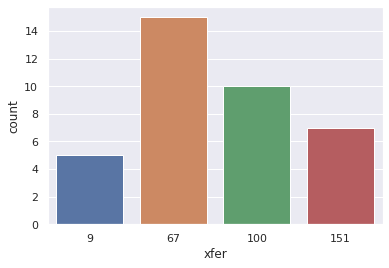

In [3]:
fig = plot_xfer_heatmap(xfers_applied)

# Pair plot of detailed costs

In [24]:
def plot_pair_grid(graph, timestamp):
    data = dict(runtime=[], flops=[], mem_acc=[], num_kernels=[], graph=[])
    
    if not isinstance(graph, list):
        graph = [graph]
    if not isinstance(timestamp, list):
        timestamp = [timestamp]
    
    
    for i, _ in enumerate(graph):
        path = f'../logs/xflowrl/{graph[i]}/{timestamp[i]}/runtime_info.json'
        detailed_costs = load_json(path)

        for e in detailed_costs:
            for k, v in e.items():
                data[k].append(v)
        data['graph'].extend([graph[i]] * len(detailed_costs))

    df = pd.DataFrame.from_dict(data)
    g = sns.PairGrid(df, hue='graph')
    g.map_diag(sns.histplot)
    g.map_offdiag(sns.scatterplot)
    # g.add_legend()
    labels = ['Runtime', 'FLOPS', 'Memory Access', 'Kernels']
    for i, ax in enumerate(g.axes[-1,:]):
        xlabel = ax.xaxis.set_label_text(labels[i])
    for i, ax in enumerate(g.axes[:,0]):
        ylabel = ax.yaxis.set_label_text(labels[i])
    g.savefig('../plots/pairplot_bert.pdf')

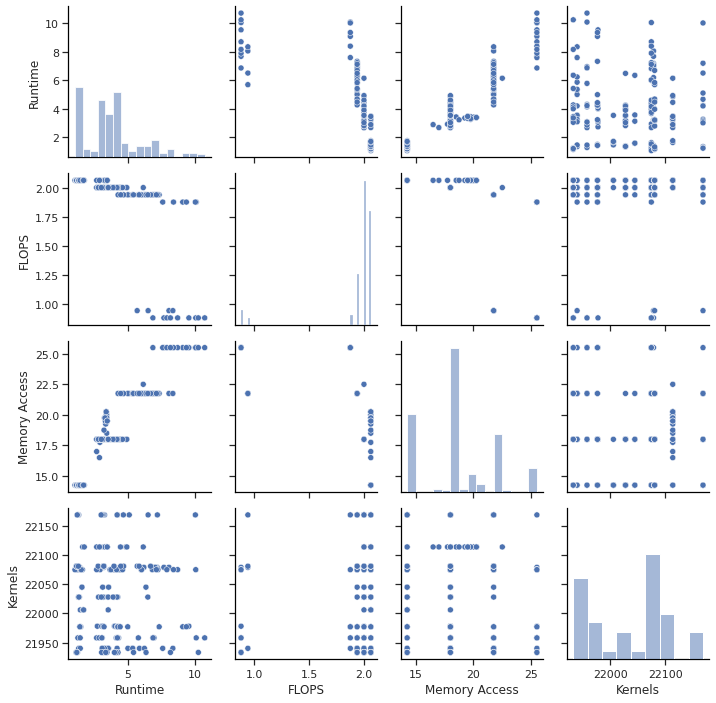

In [25]:
#graphs = ['BERT', 'squeezenet1']
#timestamps = ['20210309-161428', '20210311-184605']
#plot_pair_grid(graphs, timestamps)

#plot_pair_grid('squeezenet1', '20210311-184605')
plot_pair_grid('BERT', '20210511-174315')

# MB controller training reward line graph

In [21]:
def plot_training_reward(graphs, save_name, fix=False, title=''):
    graph_map = {'squeezenet1': 'SqueezeNet1.1', 'resnet18': 'ResNet18', 'resnet50': 'ResNet50', 'InceptionV3': 'InceptionV3', 'BERT': 'BERT'}
    graph_names = []
    all_df = pd.DataFrame.from_dict(dict(value=[], timestep=[], graph=[]))
    for path, file_name in graphs:
        data = dict(value=[], timestep=[], graph=[])
        json_data = load_json(path)
        graph = file_name.split('_')[0]
        graph_names.append(graph_map[graph])
        min_v, max_v = 1e6, -1e6
        temp_vals = []
        
        for e in json_data:
            data['timestep'].append(e[1])
            temp_vals.append(e[2])
            min_v = min(min_v, e[2])
            max_v = max(max_v, e[2])
        
        if fix:
            for i in range(data['timestep'][-1] + 10, 2010, 10):
                data['timestep'].append(i)
        
        to_extend = 200 - len(temp_vals)
        if fix:
            temp_vals.extend([temp_vals[-1]] * to_extend)
            data['graph'].extend([graph] * 200)
        else:
            data['graph'].extend([graph] * len(json_data))

        data['value'].extend([(v - min_v) / (max_v - min_v) for v in temp_vals])
        #for i, v in enumerate(temp_vals[to_extend::10]):
        #    temp_vals[to_extend + (i * 10)] += np.random.normal(0, 1) * 5
        #data['value'].extend([(v - min_v) / (max_v - min_v) for v in temp_vals])

        df = pd.DataFrame.from_dict(data)
        df['value'] = df.ewm(alpha=(1 - 0.85)).mean()
        all_df = pd.concat([all_df, df])
        

    # df = pd.DataFrame.from_dict(data)
    
    # print(df.head())
    ax = sns.lineplot(x='timestep', y='value', data=all_df, hue='graph')
    ax.set(xlabel='Epochs', ylabel='Normalised Reward', title=title)
    ax.legend(labels=graph_names, frameon=False)
    save_figure(save_name, '../plots', ax)

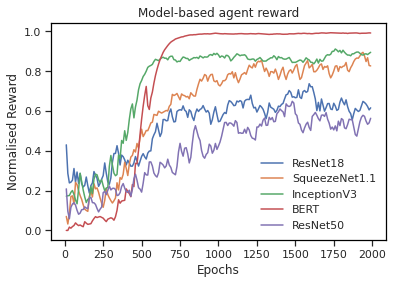

In [22]:
paths = get_files_from_dir('../chart_data/worldmodel_agent_reward_2000')
plot_training_reward(paths, 'mb_ctrl_training_reward', title='Model-based agent reward')

# Model-free agent rewards

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


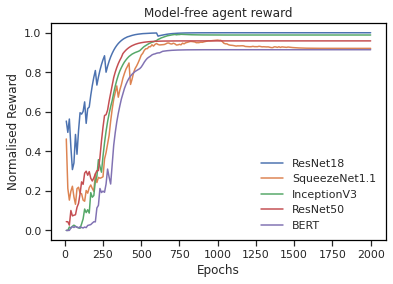

In [23]:
paths = get_files_from_dir('../chart_data/modelfree_agent_reward')
plot_training_reward(paths, 'mf_training_reward', fix=True, title='Model-free agent reward')

# World model training loss line graph

In [19]:
def plot_training_loss_world_model(paths):
    data = dict(value=[], timestep=[], graph=[])
    
    for path, file_name in paths:
        json_data = load_json(path)
        graph = file_name.split('_')[0]
        for e in json_data:
            data['timestep'].append(e[1])
            data['value'].append(e[2])
        data['graph'].extend([graph] * len(json_data))

    df = pd.DataFrame.from_dict(data)
    df['value'] = df.ewm(alpha=(1 - 0.4)).mean()
    print(df.head())
    sns.set_style('whitegrid', {'axes.grid':False, 'axes.edgecolor':'black', 'axes.linewidth':0, 'xtick.bottom':True, 'ytick.left':True})
    ax = sns.lineplot(x='timestep', y='value', data=df, hue='graph')
    ax.set(xlabel='Epochs', ylabel='Negative Log-likelihood Loss', title='World Model Training Loss')
    ax.legend(labels=['BERT', 'ResNet50', 'SqueezeNet1.1', 'InceptionV3', 'ResNet18'], frameon=False)
    save_figure('mb_training_loss', '../plots', ax)

      value  timestep graph
0  0.874853        10  BERT
1  0.855583        20  BERT
2  0.492447        30  BERT
3  0.363423        40  BERT
4  0.245316        50  BERT


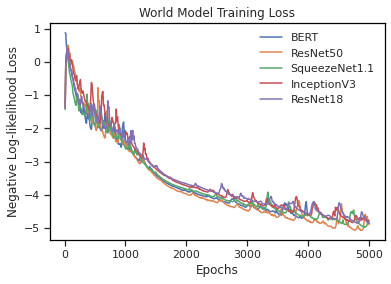

In [20]:
paths = get_files_from_dir('../chart_data/worldmodel_loss')
plot_training_loss_world_model(paths)

# Model-free reward functions

In [7]:
def plot_training_reward_func(graphs, save_name, exclude=[], title=''):
    func_map = {'r0': 'R0', 'r1': 'R1', 'r2': 'R2', 'r3': 'R3', 'r4': 'R4', 'r5': 'R5'}
    func_names = []
    all_df = pd.DataFrame.from_dict(dict(value=[], timestep=[], rfunc=[]))
    for path, file_name in graphs:
        data = dict(value=[], timestep=[], rfunc=[])
        json_data = load_json(path)
        rwd_func = file_name.split('_')[0]
        if rwd_func in exclude:
            continue
        func_names.append(func_map[rwd_func])
        min_v, max_v = 1e6, -1e6
        temp_vals = []
        
        for e in json_data:
            data['timestep'].append(e[1])
            temp_vals.append(e[2])
            min_v = min(min_v, e[2])
            max_v = max(max_v, e[2])
        
        data['rfunc'].extend([func_map[rwd_func]] * len(json_data))
        data['value'].extend([(v - min_v) / (max_v - min_v) for v in temp_vals])

        df = pd.DataFrame.from_dict(data)
        df['value'] = df.ewm(alpha=(1 - 0.85)).mean()
        all_df = pd.concat([all_df, df])
        
    ax = sns.lineplot(x='timestep', y='value', data=all_df, hue='rfunc', ci=None)
    ax.set(xlabel='Epochs', ylabel='Normalised Reward', title=title)
    ax.legend(labels=func_names, frameon=False)
    save_figure(save_name, '../plots', ax)

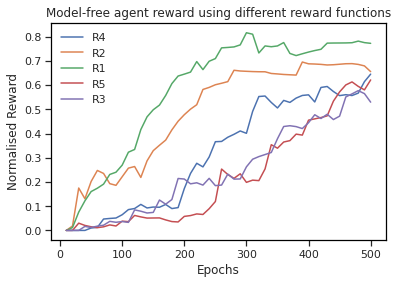

In [8]:
paths = get_files_from_dir('../chart_data/modelfree-reward-func')
plot_training_reward_func(paths, 'mf_reward_func', exclude=['r0'], title='Model-free agent reward using different reward functions')

# Baseline methods runtimes

In [9]:
def plot_runtimes_bar_chart(paths):
    backend_map = {'tf': 'TensorFlow', 'trt': 'TensorRT', 'taso': 'TASO', 'xflowrl_mf': 'XflowRL', 'xflowrl_mb': 'XflowRL'}
    graph_map = {'squeezenet': 'SqueezeNet1.1', 'resnet18': 'ResNet18', 'resnet50': 'ResNet50', 'inceptionv3': 'InceptionV3', 'bert': 'BERT'}
    data = dict(runtime=[], backend=[], graph=[])
    graph_order = []
    for path, _ in paths:
        json_data = load_json(path)
        print(json_data.keys())
        for k in json_data.keys():
            #temp_runtime = []
            #max_v, min_v = float(-1e6), float(1e6)
            for backend, obj in json_data[k]['runtime'].items():
                if backend != 'xflowrl_mf' and backend != 'xflowrl_mb':
                    if isinstance(obj['mean'], list):
                        data['runtime'].extend(obj['mean'])
                        data['backend'].extend([backend_map[backend]] * len(obj['mean']))
                        data['graph'].extend([k] * len(obj['mean']))
                    else:
                        data['runtime'].append(obj['mean'])
                    #max_v, min_v = max(max_v, obj['mean']), min(min_v, obj['mean'])
                    #temp_runtime.append(obj['mean'])
                        data['backend'].append(backend_map[backend])
                        data['graph'].append(k)
            
            # data['runtime'].extend([(v - min_v) / (max_v - min_v) for v in temp_runtime])
            graph_order.append(k)
            
    print(data)
    df = pd.DataFrame.from_dict(data)
    plot_order = df.groupby('')['Deaths'].sum().sort_values(ascending=False).index.values
    print(df.head())
    
    g = sns.catplot(x='backend', y='runtime', col='graph',
                    data=df, kind='bar', saturation=0.6, sharey=False, aspect=0.6)
    g.set_axis_labels('', 'Inference Time (ms)', fontsize=16)
    axes = g.axes.flatten()
    graphs = ['SqueezeNet1.1', 'ResNet18', 'ResNet50', 'InceptionV3', 'BERT']
    for i, label in enumerate(graphs):
        axes[i].set_title(label, fontsize=16)
    #for i, label in enumerate(graphs):
    #        g.axes[0,i].set_xlabel(label, fontsize=16)
    
    for ax in axes:
        g.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_color('black')

        for c in ax.containers:
            runtime_labels = [f'X{1-((v.get_height()-c[0].get_height())/c[0].get_height()):.2f}' for v in c]
            #ax.bar_label(c, labels=runtime_labels, label_type='edge', fontweight='bold')
            ax.bar_label(c, labels=runtime_labels, label_type='center', fontweight='bold')
    # show_values_on_bars(axes)
    g.savefig('../plots/baseline_runtimes_test.eps')

dict_keys(['squeezenet', 'resnet18', 'resnet50', 'inceptionv3', 'bert'])
{'runtime': [4.6, 4.5, 3.5, 3.4, 3.22, 3.22, 12.2, 12.0, 10.37, 10.3, 11.35, 11.25, 26.7, 26.8, 21.36, 21.33, 24.96, 24.98, 17.6, 17.5, 14.2, 14.1, 13.8, 13.9, 4.1, 4.0, 3.6, 3.6, 2.03, 2.01], 'backend': ['TensorFlow', 'TensorFlow', 'TensorRT', 'TensorRT', 'TASO', 'TASO', 'TensorFlow', 'TensorFlow', 'TensorRT', 'TensorRT', 'TASO', 'TASO', 'TensorFlow', 'TensorFlow', 'TensorRT', 'TensorRT', 'TASO', 'TASO', 'TensorFlow', 'TensorFlow', 'TensorRT', 'TensorRT', 'TASO', 'TASO', 'TensorFlow', 'TensorFlow', 'TensorRT', 'TensorRT', 'TASO', 'TASO'], 'graph': ['squeezenet', 'squeezenet', 'squeezenet', 'squeezenet', 'squeezenet', 'squeezenet', 'resnet18', 'resnet18', 'resnet18', 'resnet18', 'resnet18', 'resnet18', 'resnet50', 'resnet50', 'resnet50', 'resnet50', 'resnet50', 'resnet50', 'inceptionv3', 'inceptionv3', 'inceptionv3', 'inceptionv3', 'inceptionv3', 'inceptionv3', 'bert', 'bert', 'bert', 'bert', 'bert', 'bert']}
   r

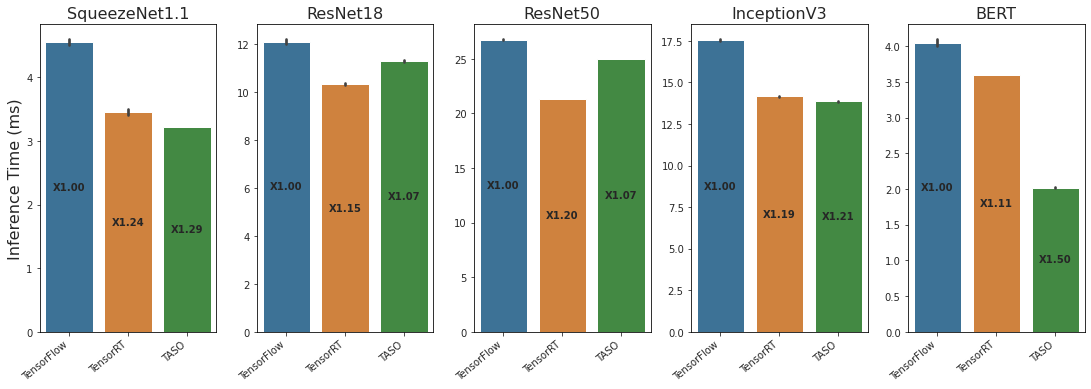

In [9]:
paths = get_files_from_dir('../results/test_runtime')
plot_runtimes_bar_chart(paths)

# World model reward prediction

In [19]:
def plot_reward_prediction(graphs):
    data = dict(value=[], timestep=[], graph=[])
    graph_map = {'squeezenet1': 'SqueezeNet1.1', 'resnet18': 'ResNet18', 'resnet50': 'ResNet50', 'InceptionV3': 'InceptionV3', 'BERT': 'BERT'}
    graph_names = []
    all_df = pd.DataFrame.from_dict(data)
    for path, file_name in graphs:
        data = dict(value=[], timestep=[], graph=[])
        json_data = load_json(path)
        graph = file_name.split('_')[0]
        graph_names.append(graph_map[graph])
        
        arr1 = json_data['reward'][-1]
        arr2 = json_data['real_reward'][-1]
        for i in enumerate(arr1):
            data['value'].append(float(i[1]))
            data['timestep'].append(i[0])
        data['graph'].extend(['pred'] * len(arr1))
        
        for i in enumerate(arr2):
            data['value'].append(float(i[1]))
            data['timestep'].append(i[0])
        data['graph'].extend(['real'] * len(arr1))
        break
        
        #min_v, max_v = 1e6, -1e6
        #temp_vals = []
        #for i, e in enumerate(json_data):
        #    data['timestep'].append(i)
        #    temp_vals.append(e[2])
        #    min_v = min(min_v, e[2])
        #    max_v = max(max_v, e[2])
        #data['value'].extend([(v - min_v) / (max_v - min_v) for v in temp_vals])
        #data['graph'].extend([graph] * len(json_data))
        #df = pd.DataFrame.from_dict(data)
        #df['value'] = df.ewm(alpha=(1 - 0.85)).mean()
        #all_df = pd.concat([all_df, df])
        

    df = pd.DataFrame.from_dict(data)
    
    # print(df.head())
    #g = sns.FacetGrid(df, row='sex', col='smoker')
    #g.map(sns.lineplot, 'timestep', 'tip')
    ax = sns.lineplot(x='timestep', y='value', data=df, hue='graph')
    ax.set(ylim=(0, 5))
    #ax.set(xlabel='Epochs', ylabel='Normalised Reward', title='Predicted agent reward by world model for given graph')
    #ax.legend(labels=graph_names, frameon=False)
    #save_figure('mb_ctrl_training_reward', '../plots', ax)

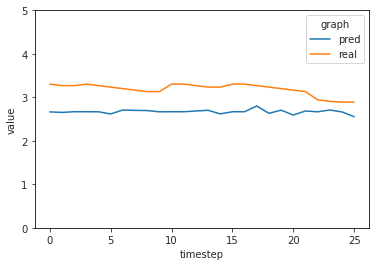

In [20]:
paths = get_files_from_dir('../results/test_reward')
plot_reward_prediction(paths)

# Runtimes Horizontal

In [13]:
def plot_runtimes_bar_chart_h(paths, exclude=[], savename='', aspect=0.65, annotation_size='large'):
    backend_map = {'tf': 'TensorFlow', 'trt': 'TensorRT', 'taso': 'TASO', 'xflowrl_mf': 'Model-free', 'xflowrl_mb': 'Model-based'}
    graph_map = {'squeezenet': 'SqueezeNet1.1', 'resnet18': 'ResNet18', 'resnet50': 'ResNet50', 'inceptionv3': 'InceptionV3', 'bert': 'BERT'}
    data = dict(runtime=[], backend=[], graph=[])
    graph_order = []
    max_v_order = []
    backends = set()
    for path, _ in paths:
        json_data = load_json(path)
        
        for k in json_data.keys():
            max_v = float(-1e6)
            temp_vals = []
            for backend, obj in json_data[k]['runtime'].items():
                if backend in exclude:
                    continue
                if isinstance(obj['mean'], list):
                    max_v = max(max_v, max(obj['mean']))
                    temp_vals.extend(obj['mean'])
                    #data['runtime'].extend(obj['mean'])
                    data['backend'].extend([backend_map[backend]] * len(obj['mean']))
                    data['graph'].extend([k] * len(obj['mean']))
                else:
                    max_v = max(max_v, obj['mean'])
                    temp_vals.append(obj['mean'])
                    data['backend'].append(backend_map[backend])
                    data['graph'].append(k)
                backends.add(backend_map[backend])

            data['runtime'].extend([1-((v - max_v) / max_v) for v in temp_vals])
            max_v_order.append(max_v)
            graph_order.append(k)
    
    df = pd.DataFrame.from_dict(data)

    colours = sns.color_palette(n_colors=len(backends))
    cmap = dict(zip(df.backend[::4], colours))

    patches = [Patch(color=v, label=k) for k, v in cmap.items()]
    
    g = sns.catplot(x='runtime', y='backend', col='graph', col_wrap=3, palette=colours,
                data=df, kind='bar', sharex=False, height=2, aspect=2)
    
    g.set_axis_labels('Relative Runtime Improvement', '')
    axes = g.axes.flatten()
    graphs = ['SqueezeNet1.1', 'ResNet18', 'ResNet50', 'InceptionV3', 'BERT']
    for i, label in enumerate(graphs):
        axes[i].set_title(label, fontsize=16)
    #for i, label in enumerate(graphs):
    #        g.axes[0,i].set_xlabel(label, fontsize=16)
    
    
    for i, ax in enumerate(axes):
        ax.axvline(1.0, color='red')
        #g.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
        ax.get_yaxis().set_ticks([])
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_color('black')
        for c in ax.containers:
            #runtime_labels = [f'X{1-((v.get_width()-c[0].get_width())/c[0].get_width()):.2f}' for v in c]
            runtime_labels = [f'{max_v_order[i] / v.get_width():.2f}ms' for v in c]
            ax.bar_label(c, labels=runtime_labels, label_type='center', fontweight='bold', fontsize=annotation_size)
            
    axes[0].legend(handles=patches, frameon=False, bbox_to_anchor=(2.3, -1), loc='center left', fontsize='large')

    g.savefig(f'../plots/runtimes_{savename}_h.eps')# Baseline runtimes

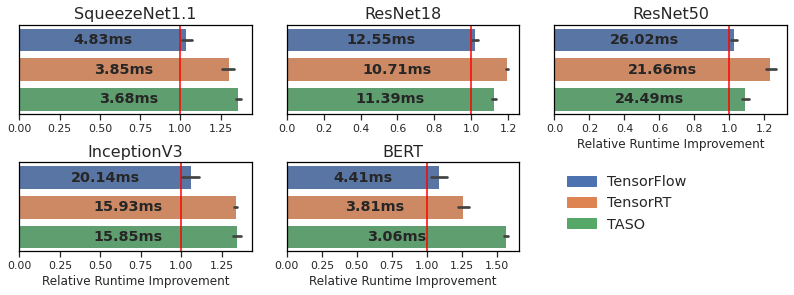

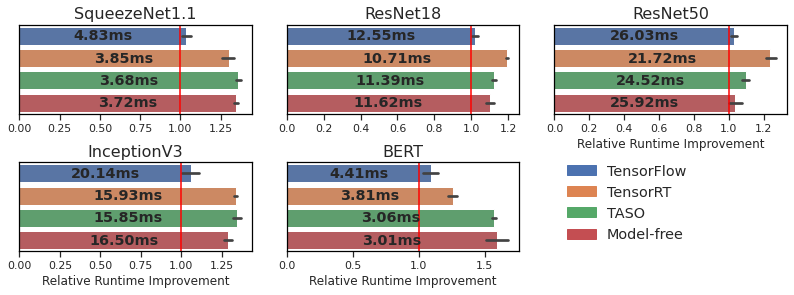

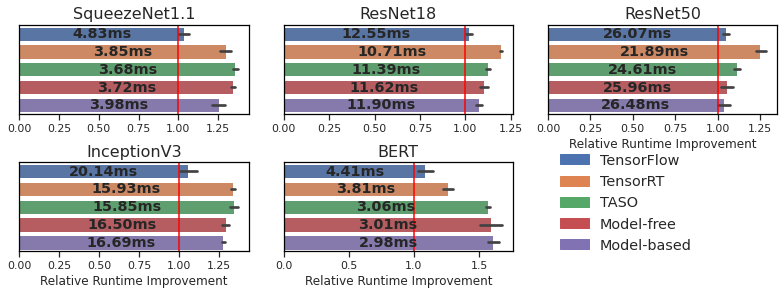

In [14]:
paths = get_files_from_dir('../results/test_runtime')
plot_runtimes_bar_chart_h(paths, exclude=['xflowrl_mf', 'xflowrl_mb'], savename='baseline')
plot_runtimes_bar_chart_h(paths, exclude=['xflowrl_mb'], savename='mf')
plot_runtimes_bar_chart_h(paths, exclude=[], savename='all')

In [48]:
def plot_runtimes_bar_chart(paths, exclude=[], savename='', aspect=0.65, annotation_size='x-large'):
    backend_map = {'tf': 'TensorFlow', 'trt': 'TensorRT', 'taso': 'TASO', 'xflowrl_mf': 'Model-free', 'xflowrl_mb': 'Model-based'}
    graph_map = {'squeezenet': 'SqueezeNet1.1', 'resnet18': 'ResNet18', 'resnet50': 'ResNet50', 'inceptionv3': 'InceptionV3', 'bert': 'BERT'}
    data = dict(runtime=[], backend=[], graph=[])
    graph_order = []
    backends = set()
    for path, _ in paths:
        json_data = load_json(path)
        print(json_data.keys())
        for k in json_data.keys():
            for backend, obj in json_data[k]['runtime'].items():
                if backend in exclude:
                    continue
                data['runtime'].append(obj['mean'])
                data['backend'].append(backend_map[backend])
                data['graph'].append(k)
                backends.add(backend_map[backend])
            graph_order.append(k)
            
    df = pd.DataFrame.from_dict(data)

    colours = sns.color_palette('tab10', n_colors=len(backends), desat=0.9)
    cmap = dict(zip(df.backend, colours))
    patches = [Patch(color=v, label=k) for k, v in cmap.items()]
    
    g = sns.catplot(x='backend', y='runtime', col='graph', col_wrap=3, palette=colours,
                data=df, kind='bar', ci=None, sharey=False, height=4, dodge=False)
    g.set_axis_labels('', 'Inference Time (ms)', fontsize=16)
    axes = g.axes.flatten()
    graphs = ['SqueezeNet1.1', 'ResNet18', 'ResNet50', 'InceptionV3', 'BERT']
    for i, label in enumerate(graphs):
        axes[i].set_title(label, fontsize=16)
    #for i, label in enumerate(graphs):
    #        g.axes[0,i].set_xlabel(label, fontsize=16)
    for ax in axes:
        g.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_color('black')
        for c in ax.containers:
            runtime_labels = [f'X{1-((v.get_height()-c[0].get_height())/c[0].get_height()):.2f}' for v in c]
            ax.bar_label(c, labels=runtime_labels, label_type='center', fontweight='bold', fontsize=annotation_size)
            
    axes[0].legend(handles=patches, frameon=False, bbox_to_anchor=(2.5, -0.6), loc='center left', fontsize='x-large')
    #show_values_on_bars(axes)
    g.savefig(f'../plots/runtimes_{savename}.eps')

dict_keys(['squeezenet', 'resnet18', 'resnet50', 'inceptionv3', 'bert'])


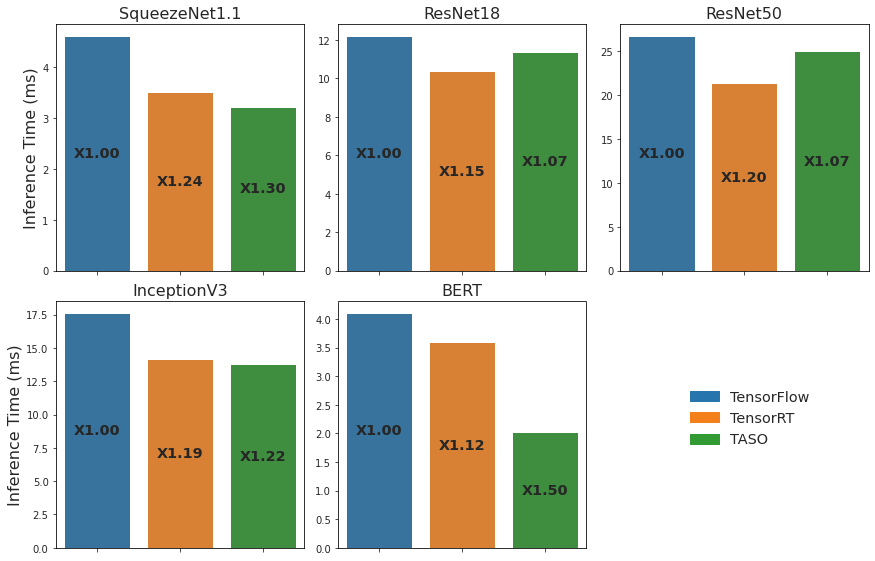

In [236]:
paths = get_files_from_dir('../results/test_runtime')
plot_runtimes_bar_chart(paths, exclude=['xflowrl_mf', 'xflowrl_mb'], savename='baseline')

# Model-based runtimes

dict_keys(['squeezenet', 'resnet18', 'resnet50', 'inceptionv3', 'bert'])


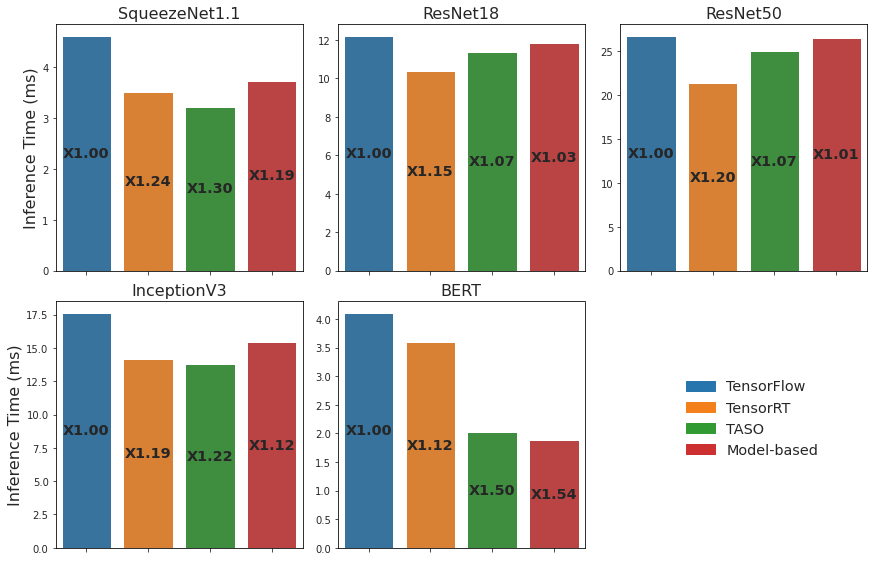

In [237]:
paths = get_files_from_dir('../results/test_runtime')
plot_runtimes_bar_chart(paths, exclude=['xflowrl_mf'], savename='mb')

# Model-free runtimes

dict_keys(['squeezenet', 'resnet18', 'resnet50', 'inceptionv3', 'bert'])


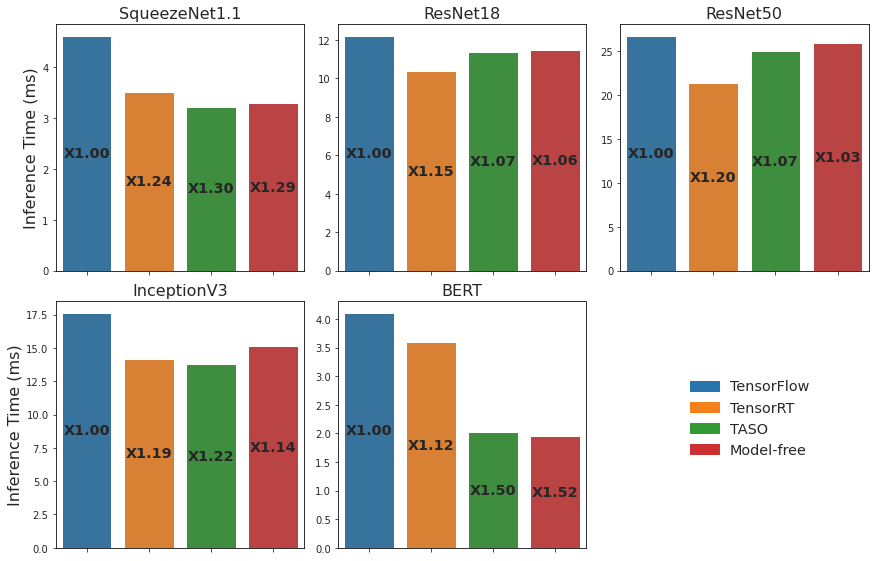

In [238]:
paths = get_files_from_dir('../results/test_runtime')
plot_runtimes_bar_chart(paths, exclude=['xflowrl_mb'], savename='mf')

# All runtimes

dict_keys(['squeezenet', 'resnet18', 'resnet50', 'inceptionv3', 'bert'])


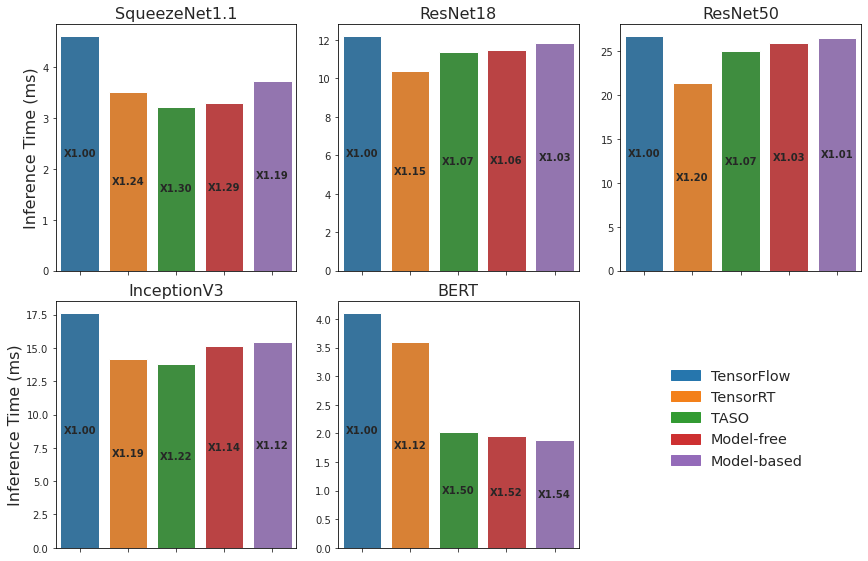

In [242]:
paths = get_files_from_dir('../results/test_runtime')
plot_runtimes_bar_chart(paths, savename='all', annotation_size='medium')

# Xfer heatmap

In [15]:
def plot_xfer_heatmap():
    xfer_id_map = {}
    xfer_applied = {
        'BERT': {'95': 24, '18': 2},
        'InceptionV3': {'13': 19},
        'SqueezeNet1.1': {'138': 7, '112': 1, '12': 8, '1': 2},
        'ResNet18': {'1': 5, '7': 4},
        'ResNet50': {'1': 17, '7': 4, '145': 1}
    }
    converted_mapping = {'xfer': [], 'graph': [], 'count': []}
    for k, v in xfer_applied.items():
        for k1, v1 in v.items():
            if k1 not in xfer_id_map:
                xfer_id_map[k1] = f's{len(xfer_id_map) + 1}'
                
            converted_mapping['xfer'].append(xfer_id_map[k1])
            converted_mapping['count'].append(int(v1))
        converted_mapping['graph'].extend([k] * len(v.items()))
    print(converted_mapping)
    
    # sorted_xfers = OrderedDict(sorted(xfer_mapping.items(), key=lambda x: int(x[0])))
    df = pd.DataFrame.from_dict(converted_mapping)
    df = df.pivot('graph', 'xfer', 'count')
    # df_formatted = df.pivot('graph', 'xfer', 'count')
    cmap = sns.color_palette("Blues", as_cmap=True)
    cmap.set_bad((0.97, 0.98, 1, 0.5))
    ax = sns.heatmap(df, linewidths=.5, annot=True, cmap=cmap, annot_kws={'fontweight': 'bold'})
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
    save_figure('xfer_heatmap', '../plots', ax)

/home/sean/.pyenv/versions/3.7.0/envs/xflow/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Blues").copy()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transpar

{'xfer': ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's7', 's8', 's7', 's8', 's9'], 'graph': ['BERT', 'BERT', 'InceptionV3', 'SqueezeNet1.1', 'SqueezeNet1.1', 'SqueezeNet1.1', 'SqueezeNet1.1', 'ResNet18', 'ResNet18', 'ResNet50', 'ResNet50', 'ResNet50'], 'count': [24, 2, 19, 7, 1, 8, 2, 5, 4, 17, 4, 1]}


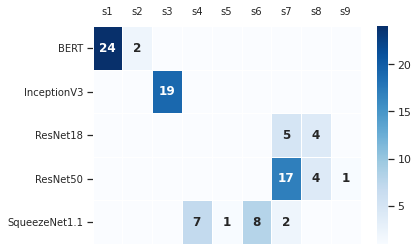

In [16]:
plot_xfer_heatmap()

# TASO training plot

In [17]:
def plot_taso_training(paths):
    data = dict(value=[], timestep=[], graph=[])
    graph_map = {'squeezenet': 'SqueezeNet1.1', 'resnet18': 'ResNet18', 'resnet50': 'ResNet50', 'inceptionv3': 'InceptionV3', 'bert': 'BERT'}
    graph_names = []
    limit = 50
    for path, file_name in paths:
        data1 = load_text(path)
        graph = file_name.split('_')[0]
        graph_names.append(graph_map[graph])
        min_v, max_v = float(1e6), float(-1e6)
        temp_vals = []
        
        for e in data1['runtime']:
            temp_vals.append(e)
            min_v = min(min_v, e)
            max_v = max(max_v, e)
            
        data['value'].extend([(v - min_v) / (max_v - min_v) for v in temp_vals[:limit]])
        data['timestep'].extend(data1['step'][:limit])
        #data['value'].extend(data1['runtime'][:50])
        data['graph'].extend([graph] * limit)

    df = pd.DataFrame.from_dict(data)
    #df['value'] = df.ewm(alpha=(1 - 0.4)).mean()
    print(df.head())
    ax = sns.lineplot(x='timestep', y='value', data=df, hue='graph')
    ax.set(xlabel='Search step', ylabel='Normalised estimated runtime', title='TASO Backtracking Search')
    ax.legend(labels=['InceptionV3', 'SqueezeNet1.1', 'ResNet50', 'ResNet18', 'BERT'], frameon=False)
    ax.set_xticks(np.arange(0, 50, 5))
    ax.set_xticklabels([str(x * 100) for x in ax.get_xticks()])
    save_figure('taso_graph_search', '../plots', ax, ext='pdf')

      value timestep        graph
0  1.000000        0  inceptionv3
1  0.924635        1  inceptionv3
2  0.845709        2  inceptionv3
3  0.781174        3  inceptionv3
4  0.716650        4  inceptionv3


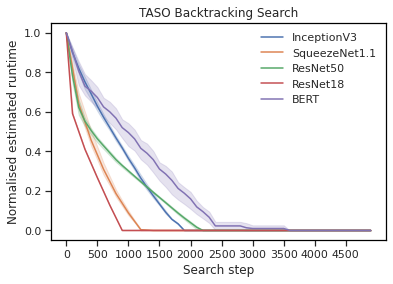

In [18]:
paths = get_files_from_dir('../chart_data/taso_training', ext='txt')
plot_taso_training(paths)

# RL convergence comparison

In [123]:
def plot_training_reward_convg_comp(graphs, save_name, agent_type='MF'):
    graph_map = {'squeezenet1': 'SqueezeNet1.1', 'resnet18': 'ResNet18', 'resnet50': 'ResNet50', 'InceptionV3': 'InceptionV3', 'BERT': 'BERT'}
    graph_names = []
    all_df = pd.DataFrame.from_dict(dict(value=[], timestep=[], graph=[]))
    for path, file_name in graphs:
        data = dict(value=[], timestep=[], graph=[])
        json_data = load_json(path)
        graph = f'{file_name.split("_")[0]}-{agent_type}'
        min_v, max_v = 1e6, -1e6
        temp_vals = []
        
        for e in json_data:
            data['timestep'].append(e[1])
            temp_vals.append(e[2])
            min_v = min(min_v, e[2])
            max_v = max(max_v, min(e[2], 95))
        
        data['graph'].extend([graph] * len(json_data))
        data['value'].extend([(v - min_v) / (max_v - min_v) for v in temp_vals])

        df = pd.DataFrame.from_dict(data)
        df['value'] = df.ewm(alpha=(1 - 0.85)).mean()
        all_df = pd.concat([all_df, df])
        
    return all_df

def plot_training_loss_convg_comp(paths, agent_type='MF'):
    data = dict(value=[], timestep=[], graph=[])
    
    for path, file_name in paths:
        json_data = load_json(path)
        graph = f'{file_name.split("_")[0]}-{agent_type}'
        for e in json_data:
            data['timestep'].append(e[1])
            data['value'].append(e[2])
        data['graph'].extend([graph] * len(json_data))

    df = pd.DataFrame.from_dict(data)
    df['value'] = df.ewm(alpha=(1 - 0.4)).mean()
    return df

In [124]:
paths = get_files_from_dir('../chart_data/modelfree_agent_reward_bert')
mf_df_rwd = plot_training_reward_convg_comp(paths, 'testt')

paths = get_files_from_dir('../chart_data/modelfree_agent_loss_bert')
mf_df_loss = plot_training_loss_convg_comp(paths)

paths = get_files_from_dir('../chart_data/modelbased_agent_reward_bert')
mb_df_rwd = plot_training_reward_convg_comp(paths, 'testt', agent_type='MB')

paths = get_files_from_dir('../chart_data/modelbased_agent_loss_bert')
mb_df_loss = plot_training_loss_convg_comp(paths, agent_type='MB')

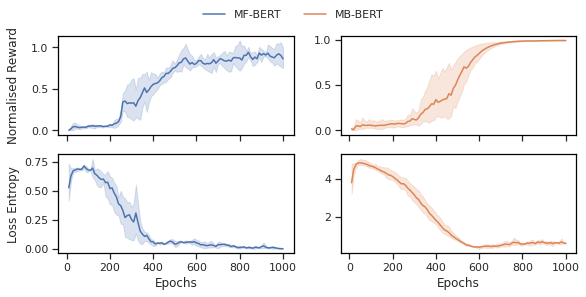

In [132]:
#from matplotlib.legend import _get_legend_handles_labels as glah
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(8,4))
fig.subplots_adjust(left=0, wspace=0.2)
color_cycle = plt.rcParams['axes.prop_cycle']()

mf_col = next(color_cycle)
mb_col = next(color_cycle)
mf_label = 'MF-BERT'
mb_label = 'MB-BERT'
sns.lineplot(ax=axes[0, 0], x='timestep', y='value', data=mf_df_rwd, label=mf_label, **mf_col) # model-free reward
sns.lineplot(ax=axes[1, 0], x='timestep', y='value', data=mf_df_loss, label=mf_label, **mf_col) # model-free loss

sns.lineplot(ax=axes[0, 1], x='timestep', y='value', data=mb_df_rwd, label=mb_label, **mb_col) # model-based reward
sns.lineplot(ax=axes[1, 1], x='timestep', y='value', data=mb_df_loss, label=mb_label, **mb_col) # model-based loss

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.legend(
  lines[:2],
  labels[:2],
  loc="upper center",
  frameon=False,
  ncol=2
)
[[c.get_legend().remove() for c in r] for r in axes]

fig.align_ylabels(axes[:, 0])
[ax.yaxis.set_label_text('') for ax in axes[:, 1]]

plt.setp(axes[-1, :], xlabel='Epochs')
plt.setp(axes[0, 0], ylabel='Normalised Reward')
plt.setp(axes[1, 0], ylabel='Loss Entropy')

save_figure('agent_convergence', path='../plots', fig=fig, ext='pdf')